## The Movie Database data analysis

This is a project that I made to deepen my knowledge of data analysis.
I am analysing movies provided by the The Movie Database (TMDB) API.

### The Scenario

Imagine you have been hired by a mid-sized production studio. They want to invest in a new film project, but they are risk-averse. They want to know: "**What are the characteristics of high-profit movies in the last 10 years?**"

### First Steps

My first step was to read the api documentation [here](https://developer.themoviedb.org). I still have doubts of what some of the parameters do because not all of them seem do be documented, but the `revenue.desc` parameter seemed a good starting point and I started gathering data using it.

Eventually I finished the `get_movie_data` function below, despite not being too complex, it took a lot of trial and error due to a few factors:

- the API is prone to errors and I needed to devise a way to save the current work in case of crashes (this part, admitedly, is still incomplete because I gathered the data before testing everything)
- the API is more generous today than in the past, but I still wanted to spare it as best as I could, so most of the code is making about 3 to 4 reqs/sec.
- halfway through I discored that the free tier only accepts requests up to the 500th page, so I had to change my logic to gather the movies. I opted to get 1.000 movies (50 pages) for the last 10 years.

The final function is the one below.

**Warning**: **it takes a few hours to download all the data**, the dataset is already present on this repo and won't be downloaded again unless we call `get_movie_data(force_update=True)`.


In [2]:
import requests
import pandas as pd
from pathlib import Path
import json
import os
from time import sleep
from datetime import datetime, timedelta
from IPython.display import clear_output


TMDB_API_READ = os.getenv("TMDB_API_READ")
HEADERS = {
    "accept": "application/json",
    "Authorization": f"Bearer {TMDB_API_READ}",
}

MOVIE_IDS_FILE = Path("movie_ids.json")

NUM_PAGES = 0


def get_movie_ids(num_years=10):
    """Get a list of movie IDs sorted by revenue. The function automatically returns after reaching the last page."""
    current_year = datetime.now().year
    try:
        with MOVIE_IDS_FILE.open("r") as f:
            movie_ids = json.load(f)
    except:
        movie_ids = []

    url = "https://api.themoviedb.org/3/discover/movie"
    MAX_PAGES_PER_YEAR = 50  # 1000 movies per year, 10_000 movies total

    for year in range(current_year - num_years, current_year):
        for page in range(1, MAX_PAGES_PER_YEAR + 1):
            params = {
                "include_adult": "false",
                "include_video": "false",
                "language": "en-US",
                "page": page,
                "sort_by": "revenue.desc",
                "primary_release_year": year,
            }

            response = requests.get(url, headers=HEADERS, params=params)
            if response.status_code == 200:
                response = response.json()
                results = response.get("results", [])
                for movie in results:
                    movie_ids.append(movie["id"])
                with open(MOVIE_IDS_FILE, "w") as f:
                    f.write(json.dumps(movie_ids))  # save results to f
                clear_output(wait=True)
                print(f"Year {year} - {page}/{response.get("total_pages")} pages")
                if page >= response.get("total_pages"):
                    print("Final page reached.")
                    return

            else:
                print(f"Error on page {page}: {response.status_code} - {response.text}")
                return

            sleep(0.3)  # To avoid overwhelming the server

    return movie_ids


def get_movie_details(movie_id):
    """Fetch specific financial details for a single movie."""
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"

    try:
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            data = response.json()
            return {
                "id": data.get("id"),
                "title": data.get("title"),
                "release_date": data.get("release_date"),
                "budget": data.get("budget"),
                "revenue": data.get("revenue"),
                "genres": [
                    g["name"] for g in data.get("genres", [])
                ],  # get only genre names
                "runtime": data.get("runtime"),
                "vote_average": data.get("vote_average"),
                "popularity": data.get("popularity"),
            }
        else:
            print(f"Error fetching details for ID {movie_id}")
            return None
    except Exception as e:
        print(f"Exception for ID {movie_id}: {e}")
        return None


def get_movie_data(force_update=False):
    path = Path("movie_data.parquet")

    if not force_update and path.exists():
        df = pd.read_parquet(path)
        if len(df) > 9000:
            print(
                "Nothing was downloaded because data is already present, if you want to update, set force_update=True"
            )
            return df
        else:
            del df

    print("Discovering movies...")
    ids = get_movie_ids(pages=10**10)
    print(f"Found {len(ids)} movie IDs.")

    print("Fetching movie details ...")
    full_movie_data = []

    for idx, m_id in enumerate(ids):
        details = get_movie_details(m_id)
        if details:
            full_movie_data.append(details)

        if idx % 10 == 0:
            clear_output(wait=True)
            print(f"Processed {idx}/{len(ids)}")

        sleep(0.3)
    print("Finished processing, saving movies")

    df = pd.DataFrame(full_movie_data)
    df.to_parquet(path, index=False, append=path.exists())
    return df

In [3]:
df = get_movie_data()

Nothing was downloaded because data is already present, if you want to update, set force_update=True


Initial look at the data, here we see the botton movies have very low budget and revenue. Did someone really made a movie with just 10 bucks? They are likely placeholders; I opted to remove them next cell.


In [4]:
df

,id,title,release_date,budget,revenue,genres,runtime,vote_average,popularity
0,299534,Avengers: Endgame,2019-04-24,356000000,2799439100,"[Adventure, Science Fiction, Action]",181,8.237,19.1569
1,76600,Avatar: The Way of Water,2022-12-14,350000000,2353096253,"[Action, Adventure, Science Fiction]",192,7.600,55.7506
2,980477,Ne Zha 2,2025-01-29,80000000,2259822417,"[Animation, Fantasy, Adventure, Action]",144,8.119,41.5190
3,299536,Avengers: Infinity War,2018-04-25,300000000,2052415039,"[Adventure, Action, Science Fiction]",149,8.235,31.3200
4,634649,Spider-Man: No Way Home,2021-12-15,200000000,1921847111,"[Action, Adventure, Science Fiction]",148,7.934,26.5115
...,...,...,...,...,...,...,...,...,...
10073,1459409,Petrifier,2025-03-08,5,10,[],60,0.000,0.0143
10074,1458024,Um Momento no Tempo,2025-04-02,1,10,[Drama],0,0.000,0.0311
10075,1456242,Apoteose,2025-03-16,10,10,[Drama],0,0.000,0.0479
10076,1452056,Les cahiers de la passion,2025-03-23,10,10,[Documentary],0,0.000,0.2644


In [ ]:
# Drop duplicates
df = df.drop_duplicates(subset=["id"], keep="first")

# Popularity is a post-hoc measure, we can only know after out movie is released
# They are also related to the TMDB API, I choose to drop it
df = df.drop(columns=["popularity", "vote_average"])

# Convert date to datetime
df["release_date"] = pd.to_datetime(df["release_date"])

# Filter too recent movies
df = df[df["release_date"] < datetime.now() - timedelta(days=20)]

# Remove rows with 0 or suspiciously low numbers
cols_to_check = ["budget", "revenue"]
for col in cols_to_check:
    df = df[df[col] > 10000]

# Simple ROI Test
df["roi"] = (df["revenue"] - df["budget"]) / df["budget"]
df[["title", "budget", "revenue", "roi"]].sort_values("roi", ascending=False).head()

# Separate by genre for analysis
df_genres = df.explode("genres")

print(f"Original clean count: {len(df)}")
print(f"Genre exploded count: {len(df_genres)}")

Original clean count: 2899
Genre exploded count: 7342


**Comedy**, **Drama** and **Horror** are our best bets for now.


In [6]:
df_genres.groupby("genres")["roi"].mean().sort_values(ascending=False)

genres
Comedy             8.496544
Drama              7.481796
Horror             6.595392
Music              6.541111
TV Movie           5.239896
Thriller           3.983358
Action             3.881639
Mystery            3.438871
Animation          3.097480
Adventure          2.830187
Family             2.562508
Fantasy            2.521423
Crime              2.502805
Romance            2.117557
Science Fiction    1.907092
Documentary        1.889017
War                1.744254
History            1.275688
Western           -0.366719
Name: roi, dtype: float64

A glance at the median tell us another history: now **Horror** is the best contender, followed by **Family** and **Adventure**. **Drama** has fallen quite low, this is likely due to outliers that pulled the average up (we will explore this more later on).


In [7]:
genre_analysis = df_genres.groupby("genres")["roi"].agg(
    ["mean", "median", "count", "std"]
)
genre_analysis = genre_analysis.sort_values(by="median", ascending=False)

genre_analysis

,mean,median,count,std
genres,,,,
Horror,6.595392,1.000000,399,33.238188
Family,2.562508,0.945422,346,8.770905
Adventure,2.830187,0.826180,548,24.122551
Mystery,3.438871,0.733479,225,9.814287
Animation,3.097480,0.722016,230,9.903109
Science Fiction,1.907092,0.648092,284,7.856249
Action,3.881639,0.559337,768,26.147338
Comedy,8.496544,0.547523,922,165.867961
Fantasy,2.521423,0.437566,310,9.073402


The graph below supports our previous hypothesis. The black dots are the outliers; a quick glance tells us that **Drama** has a lot of them! The <span style="background-color:blue;color:white">blue box</span> below contains 50% (the bulk) of our data and the black line inside is the average. We see that, indeed, **Horror** and **Family** are in good positions.

**Comedy** is a good choice if we are feeling adventurous: it still has a good ROI for the most common values and, due to the high number of outliers, have a decent chance of hitting a jackpot with 10+ ROI.

Since our client is risk-averse, however, we are leaning towards **Horror** and **Family**.


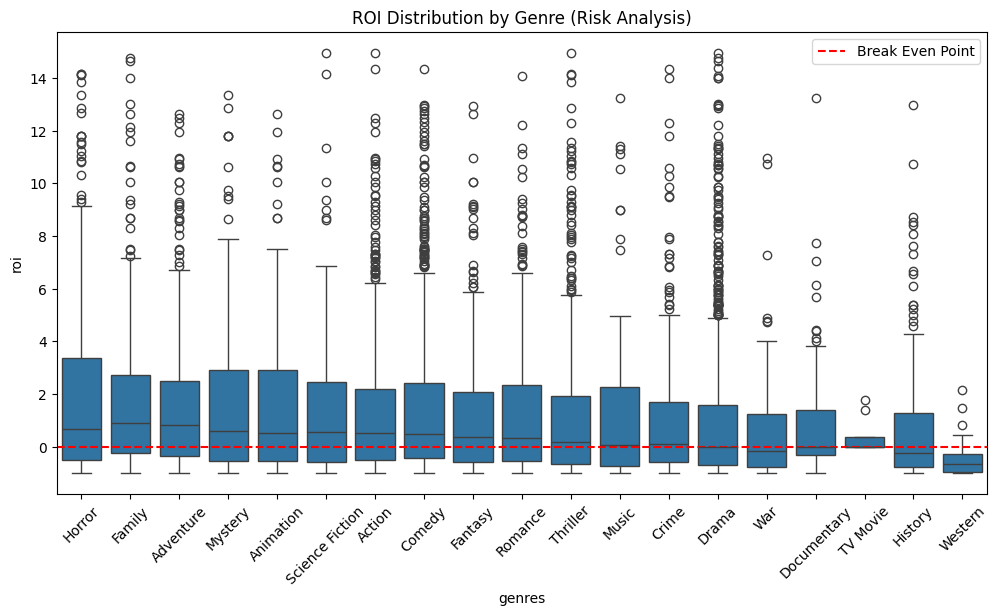

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plot_data = df_genres[df_genres["roi"] < 15].reset_index(drop=True)

sns.boxplot(x="genres", y="roi", data=plot_data, order=genre_analysis.index)

plt.xticks(rotation=45)
plt.title("ROI Distribution by Genre (Risk Analysis)")
plt.axhline(0, color="red", linestyle="--", label="Break Even Point")
plt.legend()
plt.show()

Here we see examples of outliers plus messy data. The movie **Nidja's Kitchen 2** is not an actual movie; since TMDB is crowdsourced, users can input data without restriction — including _fake data_. Our last analysis filtered by `roi < 15` so these outliers caused no impact there.


In [9]:
outliers = df_genres[df_genres["genres"] == "Comedy"].sort_values(
    by="roi", ascending=False
)
print(outliers[["id", "title", "budget", "revenue", "roi"]].head(5))

           id                title  budget    revenue          roi
4087  1198553    Nidja's Kitchen 2   50000  250000000  4999.000000
1231   513434  One Cut of the Dead   52406   27590180   525.469870
8243  1175161            Agak Laen   60000   19601819   325.696983
3230   565310         The Farewell  250300   23076657    91.195993
2535   506972             Khaltoor   15000    1000000    65.666667


The bar chart below shows us, clearly, how **Family**, **Adventure** and **Horror** and solid bets, with low chances of flopping (having less than 20% profit), high chances of being a hit (.2 to 5 times profit) and even a modarate chance of being a super hit.

My current understanding so far:

- For a heavily conservative choice (minimizing our chances of loss, but risking a lower reward) we can choose **Family**
- If we are willing to take a marginally higher risk (about 4%) for an 8% increased chance of a huge profit, then **Horror** is our choice
- If external factors or personal preferences point towards **Adventure**, that is also a solid decision


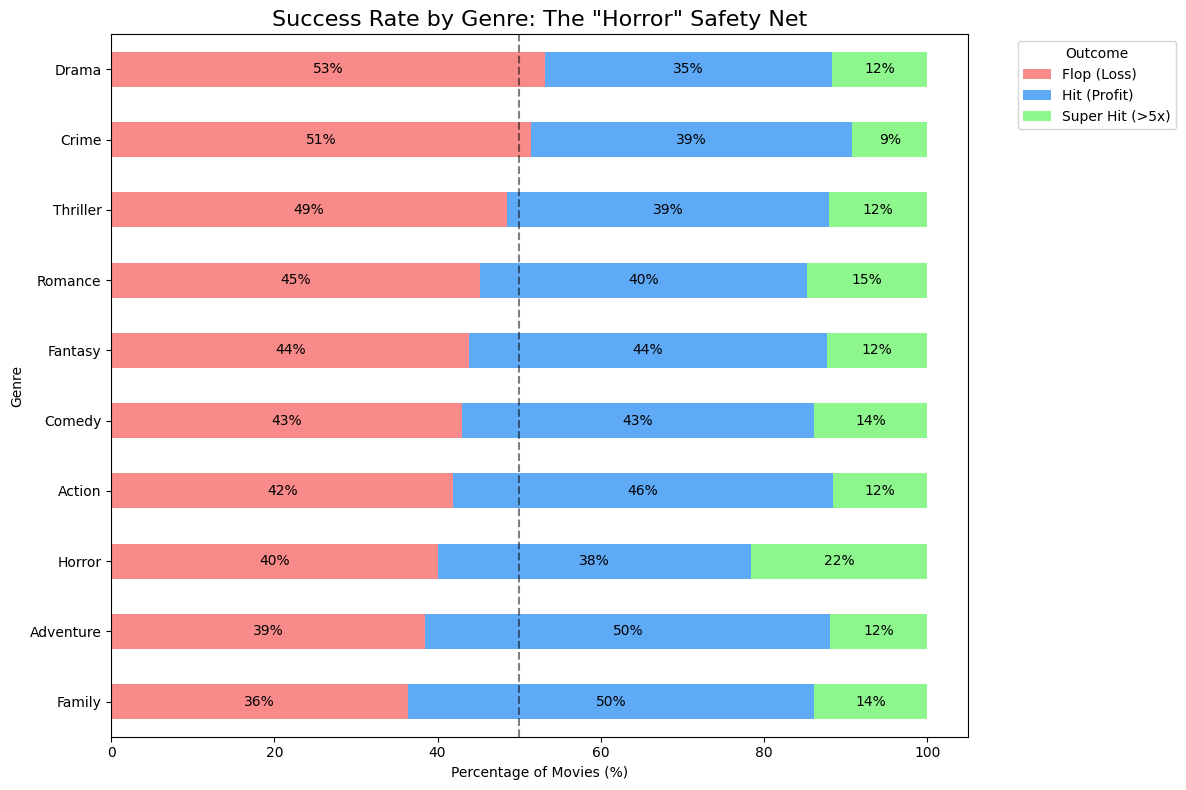

In [10]:
# Define "Flop" vs "Hit"
df_genres["outcome"] = df_genres["roi"].apply(
    lambda x: (
        "Flop (Loss)" if x < 0.2 else ("Hit (Profit)" if x < 5 else "Super Hit (>5x)")
    )
)

# Filter for top 10 genres to keep chart clean
top_genres = df_genres["genres"].value_counts().nlargest(10).index
df_outcome = df_genres[df_genres["genres"].isin(top_genres)]

# Create a pivot table of counts and convert to percent
outcome_counts = df_outcome.groupby(["genres", "outcome"]).size().unstack(fill_value=0)
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Sort by "Flop" rate
outcome_pct = outcome_pct.sort_values("Flop (Loss)")

ax = outcome_pct.plot(
    kind="barh", stacked=True, figsize=(12, 8), color=["#f88a8a", "#5eaaf7", "#8df78d"]
)

plt.title('Success Rate by Genre: The "Horror" Safety Net', fontsize=16)
plt.xlabel("Percentage of Movies (%)")
plt.ylabel("Genre")
plt.legend(title="Outcome", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.axvline(50, color="black", linestyle="--", alpha=0.5)  # 50/50 line

# Add percentage labels on bars
for c in ax.containers:
    ax.bar_label(c, fmt="%.0f%%", label_type="center", color="black", fontsize=10)

plt.tight_layout()
plt.show()

## Multivariate Analaysis

We are fairly confident of our recommendation above, let's now check how other variables like `release_date`, `budget` and `runtime` affect our decisions. We start with `release_date`.


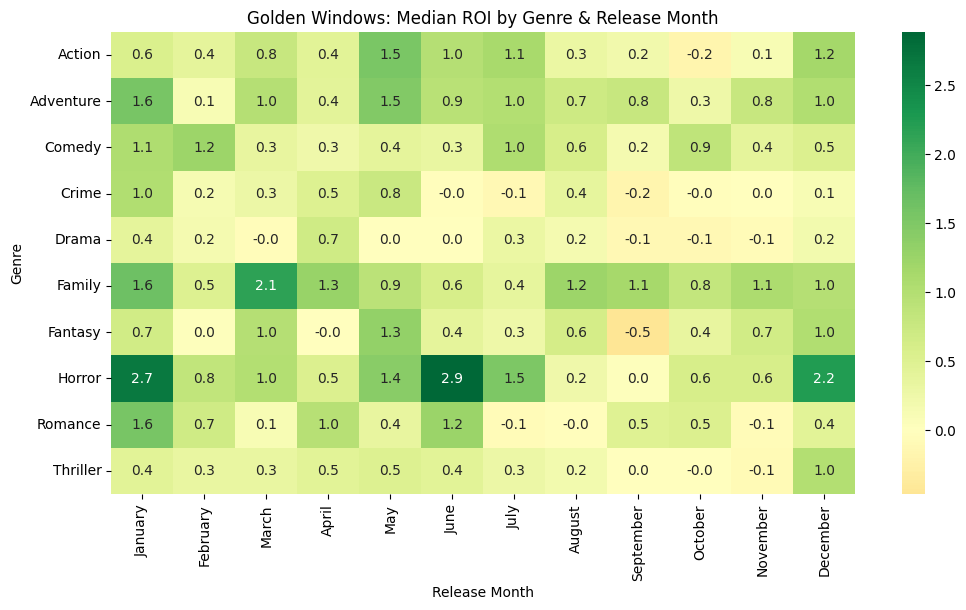

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

df_genres["release_month"] = df_genres["release_date"].dt.month_name()

# Sort order for months
df_genres["release_month"] = pd.Categorical(
    df_genres["release_month"], categories=month_order, ordered=True
)

# Top genres only for readability
top_genres = df_genres["genres"].value_counts().nlargest(10).index
df_heatmap = df_genres[df_genres["genres"].isin(top_genres)]

pivot_table = df_heatmap.pivot_table(
    values="roi", index="genres", columns="release_month", aggfunc="median"
)[month_order]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="RdYlGn", annot=True, fmt=".1f", center=0)
plt.title("Golden Windows: Median ROI by Genre & Release Month")
plt.ylabel("Genre")
plt.xlabel("Release Month")
plt.show()

The best months to release a **Horror** movie are June, January and December. This is surprising, personally, I was expecting the months surrounding Holloween - September and October - to be obvious choices. Perhaps the competition becomes so fierce that it's hard to make a profit?


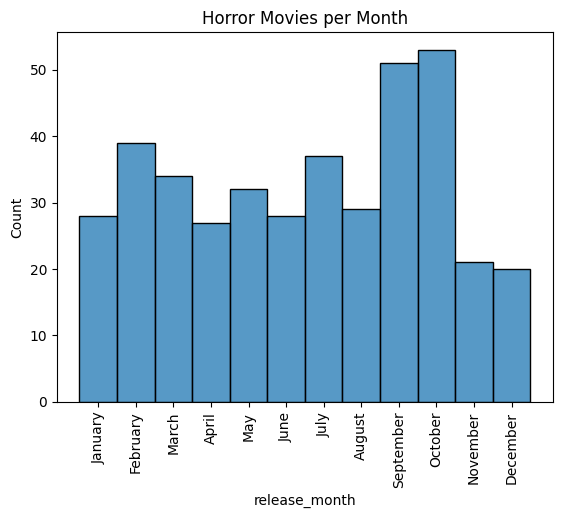

In [12]:
data_horror = df_genres[df_genres.genres == "Horror"]
sns.histplot(data=data_horror, x="release_month")
plt.xticks(rotation=90)
plt.title("Horror Movies per Month")
plt.show()

Above I sidetracked a little because I got curious about my speculation, indeed, there are more horror movies released during Halloween.

Let's return to our main task and see what is the best `budget` for our movie, we cut budget into bins and plot the ROI as a barchart.


/tmp/ipykernel_1791/3394682329.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(budget_analysis, x="budget_category", y="roi", palette="viridis")


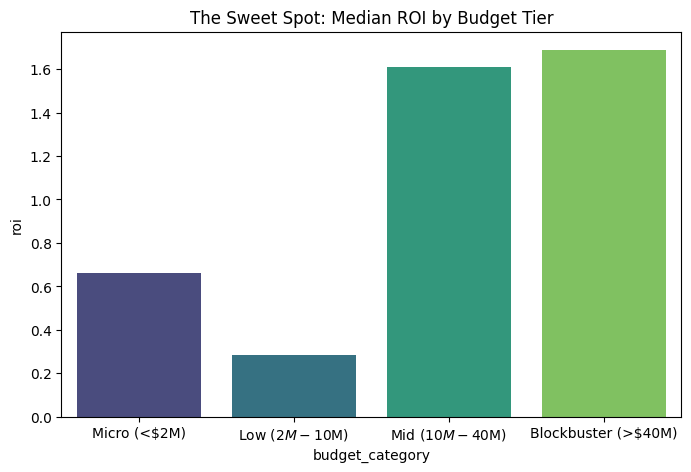

In [ ]:
bins = [0, 2_000_000, 10_000_000, 40_000_000, float("inf")]
labels = ["Micro (<$2M)", "Low ($2M-$10M)", "Mid ($10M-$40M)", "Blockbuster (>$40M)"]

df_genres["budget_category"] = pd.cut(df_genres["budget"], bins=bins, labels=labels)
df_budget = df_genres[df_genres.genres == "Horror"]
budget_analysis = df_budget.groupby("budget_category", as_index=False)["roi"].median()

plt.figure(figsize=(8, 5))
sns.barplot(budget_analysis, x="budget_category", y="roi", palette="viridis")
plt.title("The Sweet Spot: Median ROI by Budget Tier")
plt.show()

The barchart above is very intriguing. Horror movies are famous for their big hits from low budgets like _Blair Witch_ and _Paranormal Activity_.
The above made me suspect of error, possibly in the API or few data giving us a wrong picture. Below we show there are enough rows for statistical confidence on all bins. I will investigate the TMDB API for incorrect data later.

In a real life scenario, this would be a good time to get external help, consult the data providers or experts on the matter to search for errors or confirm the results, since this is a solo project, I will limit myself to what is available to me: the data.


In [14]:
df_genres[(df_genres.genres == "Horror")].groupby("budget_category").id.count()

budget_category
Micro (<$2M)           104
Low ($2M-$10M)         151
Mid ($10M-$40M)        114
Blockbuster (>$40M)     30
Name: id, dtype: int64

By looking at movies on the **blockbuster** category, we see that a lot of them have mixed categories where horror is not the primary focus (movies like Hellboy, Alien, The Mummy). We also see a lot of sequels and franchises with stablished popularity (Dracula, Nosferatu, The Meg 2, It Chapter Two), those are _safer bets_ due to being already famous. For an _original movie_, and knowing that the ROI difference between **mid budget** (10M-40M) and **blockbuster** (>40M) is very small, **mid budget** is a safer choice: it has more data for better confidence and fewer stablished franchises.


In [ ]:
df[(df.budget > 40_000_000) & (df["genres"].apply(lambda x: "Horror" in x))]

,id,title,release_date,budget,revenue,genres,runtime,roi
1102,282035,The Mummy,2017-06-06,125000000,409231607,"[Fantasy, Thriller, Action, Adventure, Horror]",110,2.273853
1119,126889,Alien: Covenant,2017-05-09,97000000,240891763,"[Horror, Science Fiction, Thriller]",122,1.483420
1152,395992,Life,2017-03-22,58000000,100541806,"[Horror, Science Fiction, Mystery]",104,0.733479
2094,345940,The Meg,2018-08-09,150000000,530517320,"[Action, Science Fiction, Horror]",113,2.536782
2133,463821,The House with a Clock in Its Walls,2018-09-15,42000000,131523093,"[Comedy, Fantasy, Family, Horror, Mystery]",105,2.131502
3094,474350,It Chapter Two,2019-09-04,79000000,473123154,"[Horror, Thriller, Drama]",169,4.988901
3136,338967,Zombieland: Double Tap,2019-10-09,42000000,122810399,"[Horror, Comedy]",99,1.924057
3159,501170,Doctor Sleep,2019-10-30,45000000,72385286,"[Horror, Fantasy]",152,0.608562
3175,456740,Hellboy,2019-04-10,50000000,55065289,"[Fantasy, Horror, Action, Adventure]",121,0.101306
4109,340102,The New Mutants,2020-04-02,67000000,49169594,"[Science Fiction, Horror, Action]",94,-0.266125
